In [1]:
import os
import shutil
import zipfile
import tensorflow as tf

2024-05-21 13:46:07.460901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 13:46:08.887860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 13:46:08.894231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 13:46:11.036380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# drive.mount('/content/drive')

In [4]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [5]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucam045/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [6]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')

In [7]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif


In [8]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [9]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucam045/project_last_sem/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 2

In [10]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [11]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 4242 files belonging to 2 classes.
Using 2758 files for training.
Found 4242 files belonging to 2 classes.
Using 1484 files for validation.


2024-05-21 13:47:54.740947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-21 13:47:54.740998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: dgxb
2024-05-21 13:47:54.741003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: dgxb
2024-05-21 13:47:54.741337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.161.3
2024-05-21 13:47:54.741353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.161.3
2024-05-21 13:47:54.741357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.161.3


In [12]:
calculate_class_weights(data_dir)

{'Happy_3': 0.6041013956137853, 'Sad_2': 2.9015047879616964}

In [41]:
#-------------------------CNN------------------------------------------------

In [42]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

In [43]:
!pip install scikeras

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

def build_model_CNN(input_shape, num_classes):
    model = tf.keras.Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [45]:
# Build the model
model_cnn = build_model_CNN(input_shape=image_size + (3,), num_classes=num_classes)

In [46]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# this has to run using dgx
history = model_cnn.fit(train_data, epochs=200, validation_data=val_data)

Epoch 1/200
87/87 [==============================] - 101s 1s/step - loss: 36.9334 - accuracy: 0.7887 - val_loss: 0.5393 - val_accuracy: 0.8415
Epoch 2/200
87/87 [==============================] - 70s 758ms/step - loss: 0.3650 - accuracy: 0.8719 - val_loss: 0.4891 - val_accuracy: 0.8618
Epoch 3/200
87/87 [==============================] - 71s 774ms/step - loss: 0.2215 - accuracy: 0.9165 - val_loss: 0.5158 - val_accuracy: 0.8665
Epoch 4/200
87/87 [==============================] - 67s 723ms/step - loss: 0.1521 - accuracy: 0.9463 - val_loss: 0.5853 - val_accuracy: 0.8793
Epoch 5/200
87/87 [==============================] - 67s 716ms/step - loss: 0.0960 - accuracy: 0.9666 - val_loss: 0.6576 - val_accuracy: 0.8854
Epoch 6/200
87/87 [==============================] - 68s 738ms/step - loss: 0.0801 - accuracy: 0.9742 - val_loss: 0.8183 - val_accuracy: 0.8847
Epoch 7/200
87/87 [==============================] - 65s 704ms/step - loss: 0.0817 - accuracy: 0.9735 - val_loss: 1.3089 - val_accuracy: 

In [48]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_cnn.evaluate(train_data, verbose=0)
print(f"Training loss for cnn: {train_loss}")
print(f"Training accuracy for cnn: {train_accuracy}")
print('--------------------------------x------------------------------------------')
# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_cnn.evaluate(val_data, verbose=0)
print(f"val loss for cnn: {Val_loss}")
print(f"val accuracy for cnn: {val_acc}")

Evaluating the model...
Training loss for cnn: 0.0018668484408408403
Training accuracy for cnn: 0.9992740750312805
--------------------------------x------------------------------------------
Evaluating the model...
val loss for cnn: 3.0988547801971436
val accuracy for cnn: 0.9163857102394104


In [49]:
# Get the true labels and predicted probabilities for the training data
true_labels = np.concatenate([y for x, y in train_data], axis=0)
predicted_probs = model_cnn.predict(train_data)
# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probs, axis=1)

87/87 [==============================] - 37s 373ms/step


In [50]:
# Print classification report
print("Classification report:")
print(classification_report(np.argmax(true_labels, axis=1), predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2295
           1       0.14      0.14      0.14       460

    accuracy                           0.71      2755
   macro avg       0.48      0.48      0.48      2755
weighted avg       0.71      0.71      0.71      2755



In [51]:
y_pred = model_cnn.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

47/47 [==============================] - 20s 341ms/step


In [52]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
print(tpr)
print(roc_auc)

{0: array([0.        , 0.        , 0.58661417, 0.5984252 , 0.5984252 ,
       0.5984252 , 0.60629921, 0.60629921, 0.60629921, 0.61417323,
       0.61811024, 0.61811024, 0.61811024, 0.61811024, 0.62204724,
       0.62204724, 0.62204724, 0.62598425, 0.62598425, 0.62992126,
       0.62992126, 0.62992126, 0.63779528, 0.63779528, 0.64173228,
       0.64173228, 0.64173228, 0.64566929, 0.65354331, 0.65354331,
       0.66141732, 0.66141732, 0.66535433, 0.66535433, 0.67322835,
       0.67322835, 0.67716535, 0.67716535, 0.68110236, 0.68110236,
       0.68110236, 0.68110236, 0.68110236, 0.68503937, 0.68503937,
       0.68503937, 0.68503937, 0.68897638, 0.68897638, 0.68897638,
       0.69291339, 0.69291339, 0.69291339, 0.69291339, 0.69291339,
       0.69685039, 0.69685039, 0.69685039, 0.69685039, 0.69685039,
       0.7007874 , 0.7007874 , 0.7007874 , 0.70472441, 0.70472441,
       0.70866142, 0.70866142, 0.70866142, 0.70866142, 0.71259843,
       0.71259843, 0.71259843, 0.71259843, 0.71653543, 0.7

In [59]:
!pip install matplotlib
import matplotlib.pyplot as plt

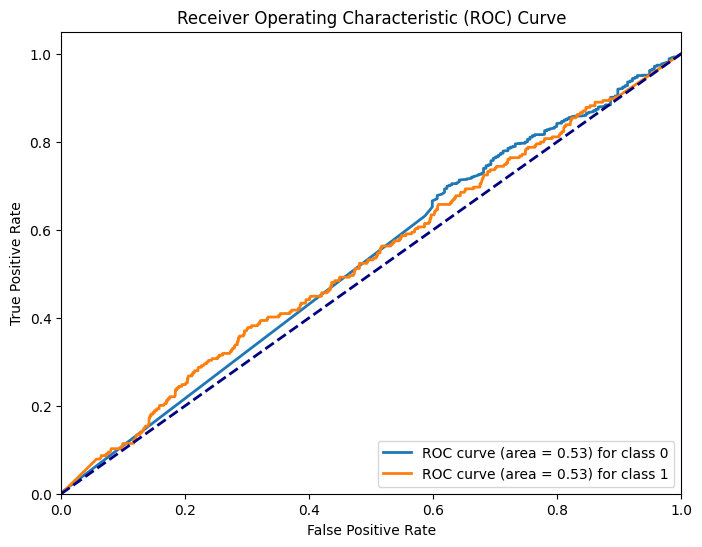

In [60]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [61]:
#---------------ResNet-----------------------------

In [23]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [14]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

In [15]:
# Add custom classification layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [16]:
# Model to be trained
model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
#Train the model---------------------------------------------------------------
history = model_resnet.fit(train_data, epochs=100, validation_data=val_data)

Epoch 1/100
87/87 [==============================] - 187s 2s/step - loss: 0.5113 - accuracy: 0.8169 - val_loss: 0.4145 - val_accuracy: 0.8268
Epoch 2/100
87/87 [==============================] - 183s 2s/step - loss: 0.4326 - accuracy: 0.8256 - val_loss: 0.3966 - val_accuracy: 0.8309
Epoch 3/100
87/87 [==============================] - 185s 2s/step - loss: 0.3991 - accuracy: 0.8350 - val_loss: 0.3857 - val_accuracy: 0.8396
Epoch 4/100
87/87 [==============================] - 185s 2s/step - loss: 0.3707 - accuracy: 0.8463 - val_loss: 0.3761 - val_accuracy: 0.8389
Epoch 5/100
87/87 [==============================] - 192s 2s/step - loss: 0.3518 - accuracy: 0.8426 - val_loss: 0.3571 - val_accuracy: 0.8430
Epoch 6/100
87/87 [==============================] - 174s 2s/step - loss: 0.3385 - accuracy: 0.8470 - val_loss: 0.3721 - val_accuracy: 0.8464
Epoch 7/100
87/87 [==============================] - 181s 2s/step - loss: 0.3230 - accuracy: 0.8510 - val_loss: 0.3509 - val_accuracy: 0.8423
Epoch 

2024-05-21 15:49:02.725303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 180 of 256
2024-05-21 15:49:09.002060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


87/87 [==============================] - 210s 2s/step - loss: 0.1314 - accuracy: 0.9333 - val_loss: 0.4109 - val_accuracy: 0.9158
Epoch 40/100
87/87 [==============================] - 201s 2s/step - loss: 0.1316 - accuracy: 0.9340 - val_loss: 0.4298 - val_accuracy: 0.9030
Epoch 41/100
87/87 [==============================] - 209s 2s/step - loss: 0.1144 - accuracy: 0.9540 - val_loss: 0.4665 - val_accuracy: 0.9023
Epoch 42/100
87/87 [==============================] - 196s 2s/step - loss: 0.1325 - accuracy: 0.9373 - val_loss: 0.4844 - val_accuracy: 0.9057
Epoch 43/100
87/87 [==============================] - 201s 2s/step - loss: 0.1180 - accuracy: 0.9434 - val_loss: 0.4353 - val_accuracy: 0.9057
Epoch 44/100
87/87 [==============================] - 202s 2s/step - loss: 0.1081 - accuracy: 0.9558 - val_loss: 0.5183 - val_accuracy: 0.9164
Epoch 45/100
87/87 [==============================] - 198s 2s/step - loss: 0.0954 - accuracy: 0.9558 - val_loss: 0.5303 - val_accuracy: 0.9111
Epoch 46/100

In [20]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_resnet.evaluate(train_data, verbose=0)
print(f"Training loss for resnet: {train_loss}")
print(f"Training accuracy for resnet: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_resnet.evaluate(val_data, verbose=0)
print(f"val loss for resnet: {Val_loss}")
print(f"val accuracy for resnet: {val_acc}")

Evaluating the model...
Training loss for resnet: 0.023563215509057045
Training accuracy for resnet: 0.9970993399620056
Evaluating the model...
val loss for resnet: 0.7525481581687927
val accuracy for resnet: 0.9258760213851929


In [21]:
y_pred = model_resnet.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

47/47 [==============================] - 64s 1s/step


In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(fpr[i])
    print(tpr[i])
print(roc_auc)

[0.         0.01158301 0.38996139 0.39382239 0.41698842 0.43629344
 0.44401544 0.44401544 0.44787645 0.45559846 0.46718147 0.47104247
 0.47876448 0.48648649 0.48648649 0.49034749 0.49034749 0.49420849
 0.4980695  0.4980695  0.5019305  0.5019305  0.5019305  0.5019305
 0.5019305  0.5019305  0.50579151 0.50579151 0.50579151 0.50579151
 0.50579151 0.50579151 0.50579151 0.50965251 0.51737452 0.52123552
 0.52509653 0.52509653 0.52509653 0.52895753 0.53281853 0.53281853
 0.53667954 0.53667954 0.53667954 0.54054054 0.54054054 0.54054054
 0.54440154 0.54440154 0.54440154 0.54440154 0.54826255 0.54826255
 0.55212355 0.55212355 0.55598456 0.55598456 0.55598456 0.55598456
 0.55598456 0.55598456 0.55598456 0.55598456 0.55598456 0.55598456
 0.55598456 0.55598456 0.55984556 0.55984556 0.56370656 0.56370656
 0.57142857 0.57142857 0.57528958 0.57528958 0.57528958 0.57528958
 0.57528958 0.57915058 0.57915058 0.58301158 0.58301158 0.58687259
 0.58687259 0.59073359 0.59073359 0.59073359 0.59459459 0.59845

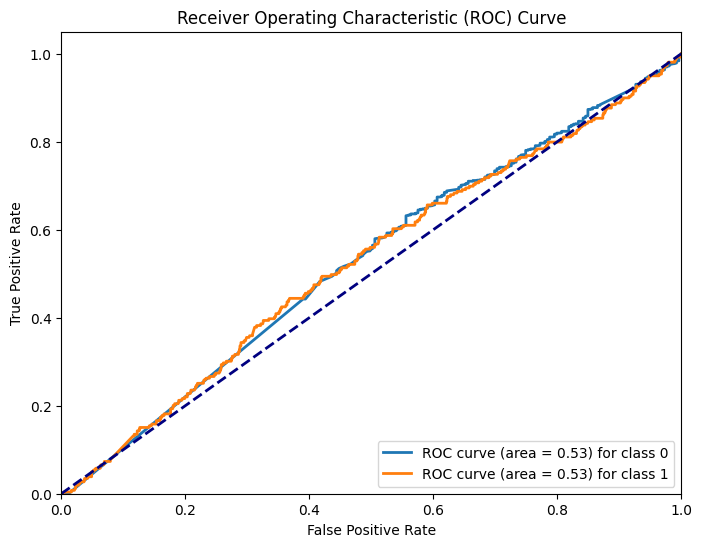

In [25]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#----------------resnet+Cnn----------------------------------------#

In [ ]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [ ]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom CNN layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Model to be trained
model_resnet_cnn = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model_resnet_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model using dgx------------------------------------------------
history = model_resnet_cnn.fit(train_data, epochs=100, validation_data=val_data)

In [ ]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_resnet_cnn.evaluate(train_data, verbose=0)
print(f"Training loss for resnet+cnn: {train_loss}")
print(f"Training accuracy for resnet+cnn: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_resnet_cnn.evaluate(val_data, verbose=0)
print(f"val loss for resnet+cnn: {Val_loss}")
print(f"val accuracy for resnet+cnn: {val_acc}")

In [ ]:
y_pred = model_resnet_cnn.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(fpr[i])
    print(tpr[i])
print(roc_auc)

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#------------------------------vgg----------------------------------

In [ ]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

In [ ]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom classification layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
#Model to be trained
model_vgg = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train with dgx----------------------------------------------------------------
history = model_vgg.fit(train_data, epochs=10, validation_data=val_data)

In [ ]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_vgg.evaluate(train_data, verbose=0)
print(f"Training loss for vgg: {train_loss}")
print(f"Training accuracy for vgg: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_vgg.evaluate(val_data, verbose=0)
print(f"val loss for vgg: {Val_loss}")
print(f"val accuracy for vgg: {val_acc}")

In [ ]:
y_pred = model_vgg.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
print(tpr)
print(roc_auc)

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.4f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()